# Clustering Geolocation Data Intelligently in Python
We have taxi rank locations, and want to define key clusters of these taxis where we can build service stations for all taxis operating in that region.

## Prerequisites
- Basic Matplotlib skills for plotting 2-D data clearly.
- Basic understanding of Pandas and how to use it for data manipulation.
- The concepts behind clustering algorithms, although we will go through this throughout the project.

## Project Outline

[**Task 1**](#task1): Exploratory Data Analysis

[**Task 2**](#task2): Visualizing Geographical Data

[**Task 3**](#task3): K-Means Clustering

[**Task 4**](#task4): DBSCAN

[**Task 5**](#task5): HDBSCAN

[**Task 6**](#task6): Addressing Outliers


In [84]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive

from collections import defaultdict

import hdbscan
import folium
import re

import googletrans
from googletrans import Translator

translator = Translator()
translated_ru = translator.translate('улица Петровка, дом 10', dest='en')
translated_ru.text

cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

<a id='task1'></a>
# Task 1: Exploratory Data Analysis

In [85]:
df = pd.read_csv('moscow_taxi_data.csv',encoding="windows-1251", usecols=['Longitude_WGS84_en', 'Latitude_WGS84_en', 'Address_en'])
df.columns = ['address', 'LON', 'LAT']

In [86]:
df.head()

,address,LON,LAT
0,"Цветной бульвар, дом 15, строение 1",37.620986,55.771196
1,"улица Петровка, дом 10",37.617991,55.762529
2,"улица Петровка, пересечение с улицей Кузнецкий...",37.618539,55.761442
3,"улица Петровка, дом 12",37.618102,55.762768
4,"улица Петровка, дом 11",37.616575,55.762905


In [87]:
df.duplicated(subset=['LON', 'LAT']).values.any()

True

In [88]:
translations = {}

unique_elements = df['address'].unique()
for element in unique_elements:
    # add translation to the dictionary
    translations[element] = translator.translate(element).text

In [89]:
df['address'].replace(translations, inplace = True)

In [90]:
df.head()

,address,LON,LAT
0,"Tsvetnoy Boulevard, Building 15, Building 1",37.620986,55.771196
1,"Petrovka street, house 10",37.617991,55.762529
2,"Petrovka street, intersection with Kuznetskiy ...",37.618539,55.761442
3,"Petrovka street, house 12",37.618102,55.762768
4,"Petrovka street, 11",37.616575,55.762905


In [91]:
df.isna().values.any()

False

In [92]:
print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset=['LON', 'LAT'], keep='first', inplace=True)
print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (399, 3)
After dropping NaNs and dupes	:	df.shape = (394, 3)


In [93]:
df.head()

,address,LON,LAT
0,"Tsvetnoy Boulevard, Building 15, Building 1",37.620986,55.771196
1,"Petrovka street, house 10",37.617991,55.762529
2,"Petrovka street, intersection with Kuznetskiy ...",37.618539,55.761442
3,"Petrovka street, house 12",37.618102,55.762768
4,"Petrovka street, 11",37.616575,55.762905


In [94]:
X = np.array(df[['LON', 'LAT']], dtype='float64')

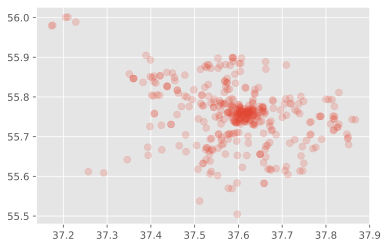

In [95]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.2, s=50)

<a id='task2'></a>
# Task 2: Visualizing Geographical Data


In [96]:
m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row.LAT, row.LON],
        radius=5,
        popup=re.sub(r'[^a-zA-Z0-9 ]+', '', row.address),
        color='#1787FE',
        fill=True,
        fill_color='#1787FE'
    ).add_to(m)

In [97]:
m

<a id='task3'></a>
# Task 3: K-Means Clustering

In [98]:
k = 70
model = KMeans(n_clusters=k, random_state=42).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_KMeans{k}'] = class_predictions

In [99]:
df.head()

,address,LON,LAT,CLUSTER_KMeans70
0,"Tsvetnoy Boulevard, Building 15, Building 1",37.620986,55.771196,62
1,"Petrovka street, house 10",37.617991,55.762529,62
2,"Petrovka street, intersection with Kuznetskiy ...",37.618539,55.761442,62
3,"Petrovka street, house 12",37.618102,55.762768,62
4,"Petrovka street, 11",37.616575,55.762905,62


In [100]:
def create_map(df, cluster_column):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

    for _, row in df.iterrows():

        # get a colour
        if row[cluster_column] ==-1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location=[row.LAT, row.LON],
            radius=5,
            popup=re.sub(r'[^а-яА-Я ]+', '', row.address),
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
    return m
m = create_map(df, 'CLUSTER_KMeans70')
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_70.html')

K=70
Silhouette Score: 0.4631400354853985


In [101]:
m

In [102]:
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 200)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
        
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}') 

100%|██████████| 198/198 [01:43<00:00,  1.91it/s]

K=116
Silhouette Score: 0.4837508307359033


<a id='task4'></a>
# Task 4: DBSCAN 
Density-Based Spatial Clustering of Applications with Noise

In [103]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions = model.labels_

df['CLUSTERS_DBSCAN'] = class_predictions

In [104]:
m = create_map(df, 'CLUSTERS_DBSCAN')

print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 7
Number of outliers found: 236
Silhouette ignoring outliers: 0.3298489967602798
Silhouette outliers as singletons: -0.01528005548198769


In [105]:
m

<a id='task5'></a>
# Task 5: HDBSCAN
Hierarchical DBSCAN

In [106]:
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2,
                        cluster_selection_epsilon=0.01)

class_predictions = model.fit_predict(X)
df['CLUSTERS_HDBSCAN'] = class_predictions

In [107]:
m = create_map(df, 'CLUSTERS_HDBSCAN')
print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

m

Number of clusters found: 20
Number of outliers found: 87
Silhouette ignoring outliers: 0.33400533642317737
Silhouette outliers as singletons: 0.08208534099378857


<a id='task6'></a>
# Task 6: Addressing Outliers


In [108]:
classifier = KNeighborsClassifier(n_neighbors=1)

In [109]:
df_train = df[df.CLUSTERS_HDBSCAN!=-1]
df_predict = df[df.CLUSTERS_HDBSCAN==-1]

In [110]:
X_train = np.array(df_train[['LON', 'LAT']], dtype='float64')
y_train = np.array(df_train['CLUSTERS_HDBSCAN'])
                   
X_predict = np.array(df_predict[['LON', 'LAT']], dtype='float64')

In [111]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [112]:
predictions = classifier.predict(X_predict)

In [113]:
df['CLUSTER_hybrid'] = df['CLUSTERS_HDBSCAN']

In [114]:
df.loc[df.CLUSTERS_HDBSCAN==-1, 'CLUSTER_hybrid'] = predictions

In [115]:
m = create_map(df, 'CLUSTER_hybrid')

In [116]:
m

In [117]:
class_predictions = df.CLUSTER_hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 20
Silhouette: 0.21322781622580297


Text(0.5, 0, 'Cluster Sizes')

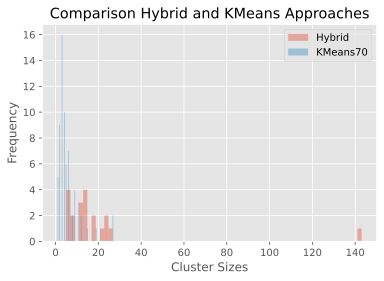

In [118]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=70, alpha=0.4,
                                                 label='Hybrid')
df['CLUSTER_KMeans70'].value_counts().plot.hist(bins=70, alpha=0.4,
                                               label='KMeans70')
plt.legend()
plt.title('Comparison Hybrid and KMeans Approaches')
plt.xlabel('Cluster Sizes')